In [111]:
model_path = 'C:/Users/woghk/OneDrive/문서/카카오톡 받은 파일/preprocessing_not_pretrained_best_model_again_disease_5 (1).h5'

In [112]:
import tensorflow as tf
from tensorflow.keras.models import load_model

In [113]:
model_with_cam = load_model(model_path)

In [114]:
with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model_with_cam.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='categorical_crossentropy',
        metrics=METRICS
    )

In [115]:
import tensorflow as tf
import os
IMAGE_HEIGHT = 112
IMAGE_WIDTH = 112
batch_size = 32

# 이미지 파일을 읽고 레이블을 설정하는 함수
def load_and_preprocess_image(image_path, label):
    # 이미지 읽기
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # 이미지 크기 조정 및 정규화
    img = tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0  # 이미지를 [0,1] 범위로 정규화
    return img, label

# 데이터 디렉토리 경로 설정
data_dir = "C:/Users/woghk/Downloads/final_test"

# 클래스 레이블 설정
class_names = ["0", "1", "2", "3", "4"]

# 이미지 파일 경로와 레이블을 리스트에 저장
file_paths = []
labels = []

# 클래스 레이블에 따라 이미지 파일 경로 및 레이블 설정
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            file_path = os.path.join(class_dir, filename)
            file_paths.append(file_path)
            labels.append(i)  # 클래스 레이블 설정

# 클래스 수 계산
num_classes = len(class_names)

# 원-핫 인코딩 수행
labels_onehot = tf.one_hot(labels, num_classes)

# 데이터셋 생성
image_paths_ds = tf.data.Dataset.from_tensor_slices(file_paths)
labels_ds = tf.data.Dataset.from_tensor_slices(labels_onehot)

# 이미지 파일 경로와 레이블을 결합하여 데이터셋 생성
test_dataset = tf.data.Dataset.zip((image_paths_ds, labels_ds))

# 이미지를 읽고 전처리하는 함수 적용
test_dataset = test_dataset.map(load_and_preprocess_image)

# 데이터셋을 셔플 및 배치 설정
test_dataset = test_dataset.shuffle(buffer_size=len(file_paths))
test_dataset = test_dataset.batch(batch_size)

# 데이터셋 사용 예시
for image_batch, label_batch in test_dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)

Image batch shape: (32, 112, 112, 3)
Label batch shape: (32, 5)


In [116]:
loss, accuracy, precision, recall = model_with_cam.evaluate(test_dataset)

188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 121ms/step - accuracy: 0.7086 - loss: 2.5487 - precision: 0.7097 - recall: 0.7053


In [117]:
def residual_block(x, filters, kernel_size=3, stride=1):
    x_shortcut = x
    x = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Shortcut path => x가 바로 이동
    if stride != 1 or x.shape[-1] != filters:
        x_shortcut = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x_shortcut)
        x_shortcut = tf.keras.layers.BatchNormalization()(x_shortcut)

    # Add the shortcut to the main path => shortcut경로와 주 경로 결합
    x = tf.keras.layers.Add()([x, x_shortcut])
    x = tf.keras.layers.Activation('relu')(x)

    return x

In [118]:
def build_resnet18(input_shape=(112, 112, 3), num_classes=5):
    input_layer = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    x = residual_block(x, filters=64, stride=1)
    x = residual_block(x, filters=64, stride=1)

    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128, stride=1)

    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256, stride=1)

    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512, stride=1)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # 분류를 위한 Fully Connected Layer
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # 모델 생성
    model = tf.keras.models.Model(inputs=input_layer, outputs=x)

    return model

In [119]:
model_with_cam = build_resnet18()

In [165]:
def get_one(ds):
    # 데이터셋에서 하나의 샘플 가져오기
    sample = next(iter(ds.take(1)))
    image = sample[0]  # 이미지
    label = sample[1]  # 레이블
    return image, label  # 이미지와 레이블 반환

Label: tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)


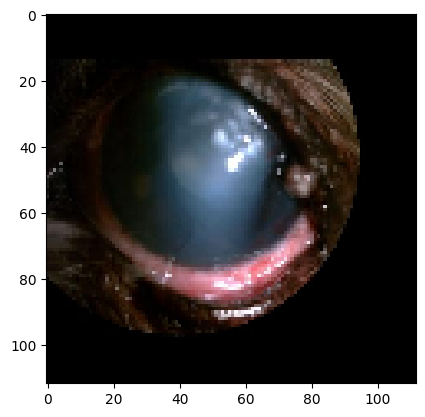

In [166]:
# 샘플 가져오기
image, label = get_one(test_dataset)

# 이미지의 배치 차원 제거하여 단일 이미지로 변환
image = image[0]  # 배치에서 첫 번째 이미지 선택
label = label[0]  # 배치에서 첫 번째 레이블 선택

print("Label:", label)
plt.imshow(image.numpy())
plt.show()

In [167]:
import os
                # 'C:/Users/woghk/OneDrive/문서/카카오톡 받은 파일/preprocessing_not_pretrained_best_model_again_disease_5 (1).h5'
cam_model_path = 'C:/Users/woghk/OneDrive/문서/카카오톡 받은 파일/preprocessing_not_pretrained_best_model_again_disease_5 (1).h5'
cam_model_predict = tf.keras.models.load_model(cam_model_path)

cam_model_predict.compile(
    loss='categorical_crossentropy', ## 변환해야함 -> sparse_categorical_crossentropy
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=METRICS,
)

In [168]:
import cv2
import numpy as np

# 이미지를 numpy 배열로 변환
image_np = image.numpy()
input_image = cv2.resize(image_np, (112, 112))
input_image = np.expand_dims(input_image, axis=0)
      
# 모델 예측
predictions = cam_model_predict.predict(input_image)
      
# 결과 출력
print(predictions)

predicted_class = np.argmax(predictions)

print(predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
[[1.2160867e-10 3.1456031e-05 4.0433153e-07 2.0872028e-12 9.9996817e-01]]
4


In [171]:
def generate_cam(model, image, label):
    # item = copy.deepcopy(item)
    # width = item['image'].shape[1]
    # height = item['image'].shape[0]
    
    # img_tensor, class_idx = normalize_and_resize_img(item) # 입력 이미지를 정규화하고 크기를 조정
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output]) 
    # model.layers[-3] => 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있기 때문
    # 원본 모델에서 마지막에서 세 번째 레이어의 출력과 원본 모델의 출력을 동시에 반환
    conv_outputs, predictions = cam_model(tf.expand_dims(image, 0))
    # 새로 정의한 모델에 이미지를 전달하여 해당 이미지의 특성 맵 (conv_outputs)과 모델의 예측 결과 (predictions)을 얻기
    conv_outputs = conv_outputs[0, :, :, :] # 특성 맵의 형태를 조정
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    # 모델의 마지막 레이어에서 클래스 가중치를 가져오기

    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    # CAM을 저장할 빈 이미지를 생성
    # for i, w in enumerate(class_weights[:, label]): # 각 클래스 가중치에 대해 반복
    #     # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
    #     cam_image += w * conv_outputs[:, :, i]
    #     # 특성 맵의 각 채널에 대해 해당 채널의 클래스 가중치와 곱한 값을 누적하여 CAM을 생성
    for i, w in enumerate(class_weights[label]): # 각 클래스 가중치에 대해 반복
      # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
      cam_image += w * conv_outputs[:, :, i]
      # 특성 맵의 각 채널에 대해 해당 채널의 클래스 가중치와 곱한 값을 누적하여 CAM을 생성

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    # CAM을 정규화
    cam_image = cam_image.numpy() # NumPy 배열로 변환
    cam_image = cv2.resize(cam_image, (224, 224)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

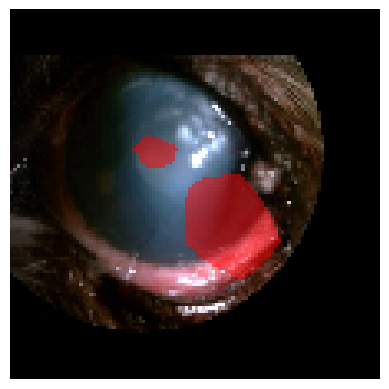

In [172]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def generate_cam(model, image, label):
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output]) 
    conv_outputs, predictions = cam_model(tf.expand_dims(image, 0))
    conv_outputs = conv_outputs[0, :, :, :] # 특성 맵의 형태를 조정
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 

    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[label]): # 각 클래스 가중치에 대해 반복
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy() # NumPy 배열로 변환
    cam_image = cv2.resize(cam_image, (224, 224)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

# Convert the original image to a NumPy array and normalize it to values ​​between 0 and 1.
original_image = image.numpy()
if np.max(original_image) > 1:
    original_image = original_image / 255.0

# Resize the CAM image to the same size as the original image
cam_image_resized = cv2.resize(cam_image, (original_image.shape[1], original_image.shape[0]))

# Convert CAM image to heatmap
cam_image_normalized = (cam_image_resized - np.min(cam_image_resized)) / (np.max(cam_image_resized) - np.min(cam_image_resized))

# Highlight only the parts of the heatmap that are above a certain threshold
threshold = 0.6 # set threshold (between 0 and 1)
mask = cam_image_normalized >= threshold

# Ensure that only non-black pixels (or pixels close to black) in the original image are considered
color_threshold = 10 / 255.0 # Adjust this threshold as needed
non_black_mask = np.any(original_image > color_threshold, axis=-1)
mask = mask & non_black_mask

# Apply red heatmap
highlighted_heatmap = np.zeros_like(original_image)
highlighted_heatmap[mask] = [1, 0, 0] # Red (RGB)

# Apply heatmap to original image
superimposed_img = original_image.copy()
superimposed_img[mask] = 0.5 * original_image[mask] + 0.5 * highlighted_heatmap[mask]

# Final image output
plt.imshow(np.uint8(superimposed_img * 255))
plt.axis('off') # Hide axis
plt.show()

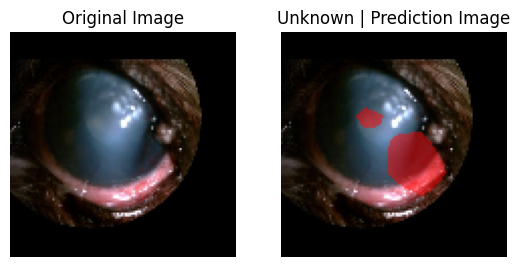

In [173]:
# 왼쪽 subplot: 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# 오른쪽 subplot: 합쳐진 이미지
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
if predicted_class == 0:
    title = '0'
elif predicted_class == 1:
    title = '1'
elif predicted_class == 2:
    title = '2'
else:
    title = 'Unknown'
plt.title(f'{title} | Prediction Image')
plt.axis('off')

# 출력
plt.show()

# SHAP

In [182]:
def integrated_gradients(model, image, baseline=None, num_steps=50):
    if baseline is None:
        baseline = np.zeros(image.shape).astype(np.float32)
    assert(baseline.shape == image.shape)
    alphas = np.linspace(0, 1, num_steps)

    images = [(baseline + alpha * (image - baseline)).astype(np.float32) for alpha in alphas]
    gradients = [compute_gradients(model, img[np.newaxis, ...]) for img in images]
    avg_gradients = np.mean(gradients, axis=0)
    integrated_grad = (image - baseline) * avg_gradients
    return integrated_grad

def compute_gradients(model, images):
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
    return tape.gradient(preds, images)

In [184]:
def predict_fn(images):
    images = images / 255.0 if np.max(images) > 1 else images
    return model_with_cam.predict(images)

# Get one sample from the test dataset
def get_one(ds):
    sample = next(iter(ds.take(1)))
    image = sample[0]
    label = sample[1]
    return image, label

image, label = get_one(test_dataset)
image = image[0].numpy()
label = label[0].numpy()
label = np.argmax(label) if label.ndim > 0 else int(label)
image = image / 255.0 if np.max(image) > 1 else image

# Generate CAM
cam_image = generate_cam(model_with_cam, image, label)

# Create a 4D background dataset
background = np.zeros((1, image.shape[0], image.shape[1], image.shape[2]))

# Apply SHAP KernelExplainer
explainer = shap.KernelExplainer(predict_fn, background)

# Get SHAP values for the image
shap_values = explainer.shap_values(image[np.newaxis, ...])

# Reshape SHAP values to match the original image shape
shap_values = np.array(shap_values[0]).reshape(image.shape)

# Normalize the SHAP values for better visualization
shap_values = (shap_values - np.min(shap_values)) / (np.max(shap_values) - np.min(shap_values))

# Plot the SHAP values
shap.image_plot([shap_values], [image])

# Create a new image with SHAP explanation overlaid on the original image
shap_overlay = image + shap_values

# Combine CAM and SHAP overlays
combined_overlay = np.maximum(cam_image, shap_overlay)

# Plot the combined result
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(image)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(mark_boundaries(image, cam_image))
ax2.set_title('CAM Overlay')
ax2.axis('off')

ax3.imshow(mark_boundaries(image, combined_overlay))
ax3.set_title('Combined CAM and SHAP Overlay')
ax3.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


DimensionError: Instance must have 1 or 2 dimensions!